📊 Carregando dados para BOVA11.SA...
✅ Dados carregados: 1823 observações
🎯 Executando backtest de 5 estratégias...
   • Testando: Buy & Hold
   • Testando: MA Cross (10,30)
   • Testando: MA Cross (20,50)
   • Testando: RSI (14,30,70)
   • Testando: RSI (21,25,75)


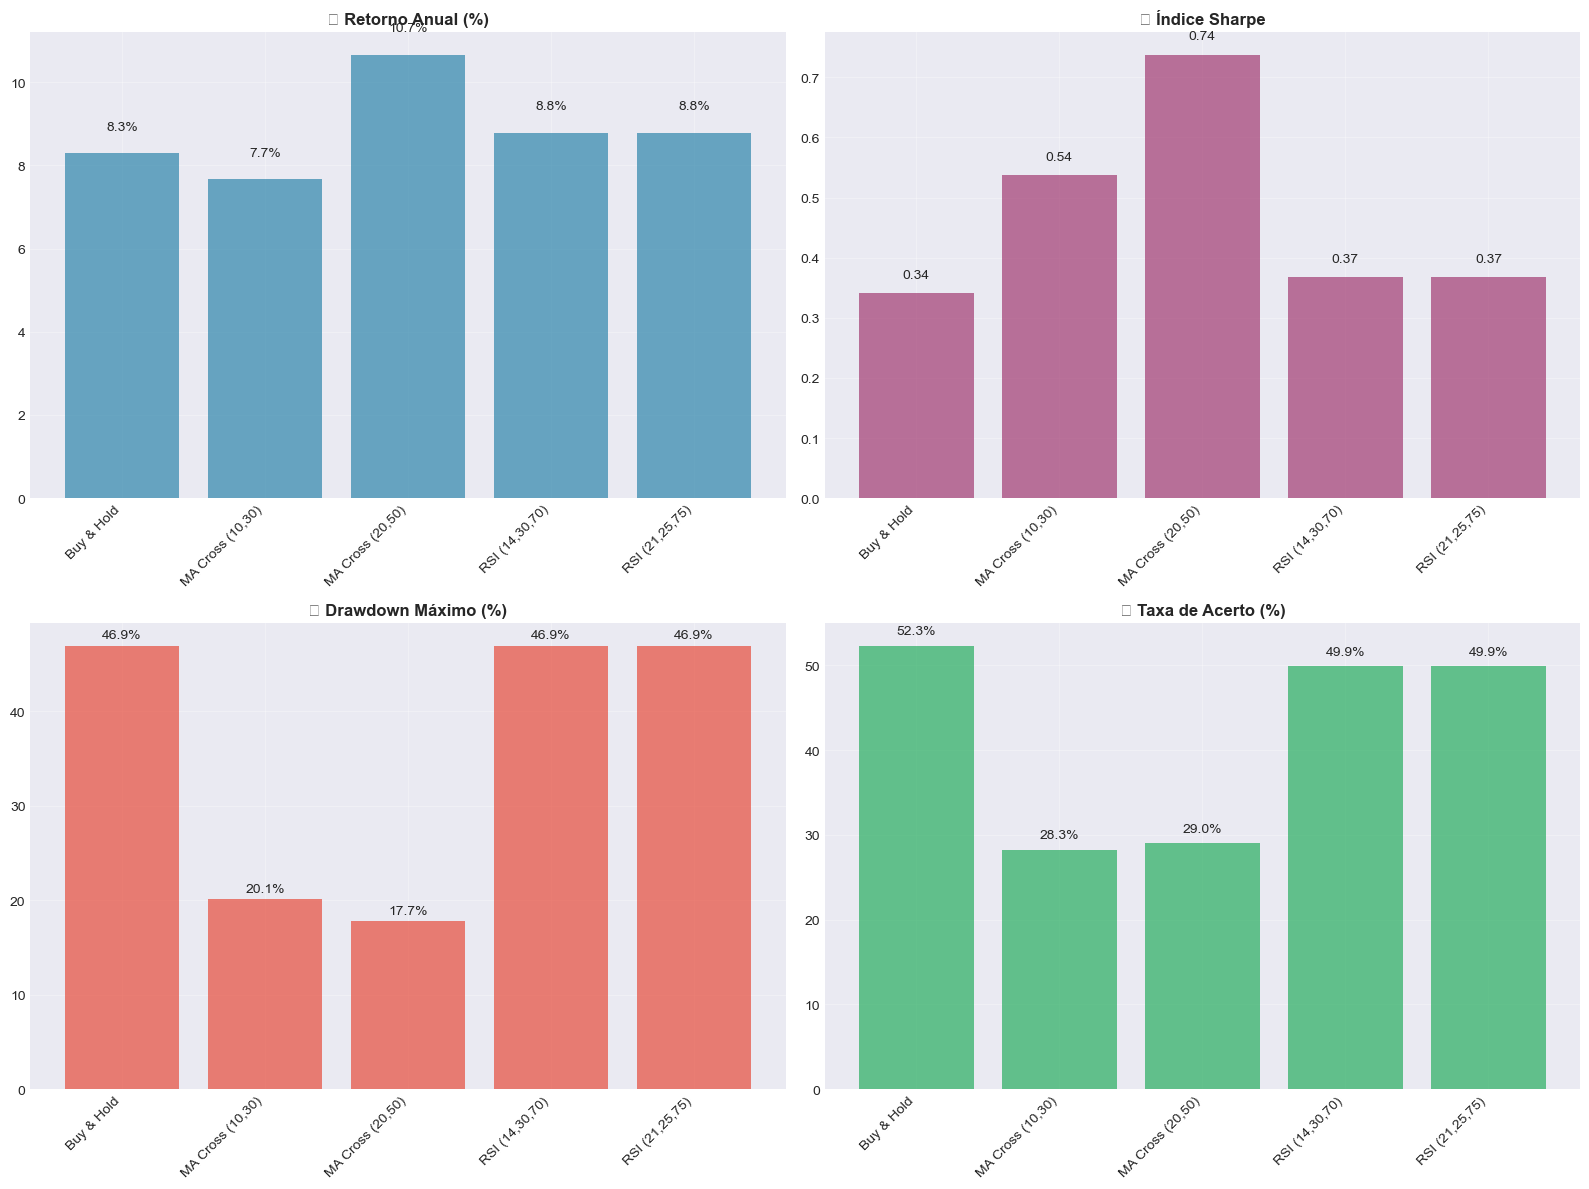

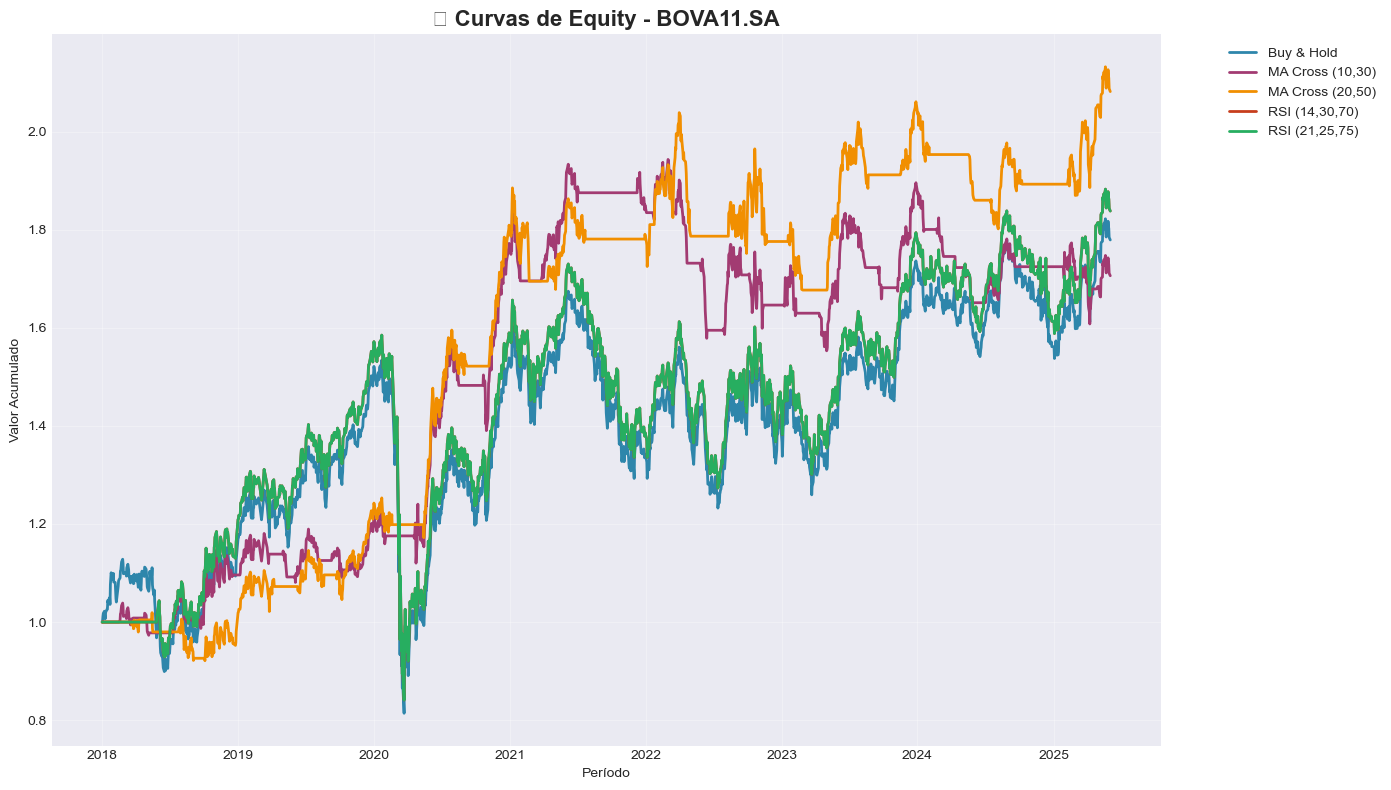

📊 RELATÓRIO DE ESTRATÉGIAS - BOVA11.SA
📅 Período: 2018-01-01 até 2025-06-03

🏆 RANKING POR ÍNDICE SHARPE:
--------------------------------------------------------------------------------
Posição  Estratégia                Retorno      Sharpe     DD Max       Trades    
--------------------------------------------------------------------------------
1        MA Cross (20,50)             10.66%     0.74    17.74%       18
2        MA Cross (10,30)              7.66%     0.54    20.07%       32
3        RSI (14,30,70)                8.78%     0.37    46.93%        0
4        RSI (21,25,75)                8.78%     0.37    46.93%        0
5        Buy & Hold                    8.29%     0.34    46.93%        0

🥇 MELHOR ESTRATÉGIA: MA Cross (20,50)
   • Retorno anual: 10.66%
   • Volatilidade: 14.45%
   • Índice Sharpe: 0.74
   • Drawdown máximo: 17.74%
   • Taxa de acerto: 29.02%

🎯 Executando Monte Carlo na melhor estratégia: MA Cross (20,50)
🎲 Monte Carlo para estratégia: MA Cross (20,5

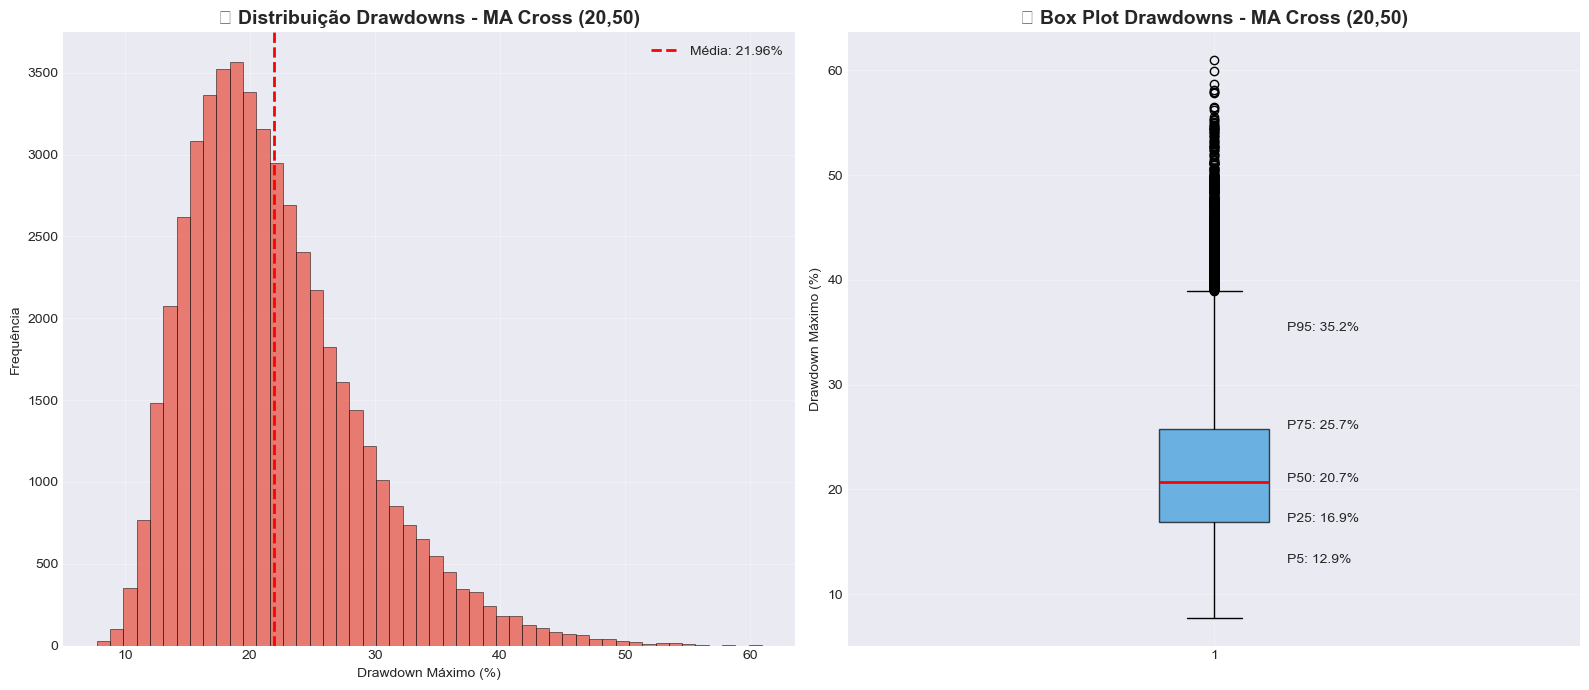


🎯 ANÁLISE DE RISCO MONTE CARLO - MA Cross (20,50)
📊 Estatísticas dos Drawdowns (3 anos, 50k simulações):
   • Drawdown médio: 21.96%
   • Drawdown mediano: 20.74%
   • Desvio padrão: 6.93%
   • Mínimo: 7.75%
   • Máximo: 60.96%

🎯 Cenários de Risco (Prob. de EXCEDER):
   • 50% chance: DD > 20.74%
   • 25% chance: DD > 25.72%
   • 10% chance: DD > 31.38%
   •  5% chance: DD > 35.15%
   •  1% chance: DD > 43.06%

⚠️  Classificação de Risco: 🟡 MÉDIO

🔄 ANÁLISE COMPARATIVA MULTI-ATIVOS

📊 Analisando PETR4.SA...
📊 Carregando dados para PETR4.SA...
✅ Dados carregados: 1347 observações
🎯 Executando backtest de 5 estratégias...
   • Testando: Buy & Hold
   • Testando: MA Cross (10,30)
   • Testando: MA Cross (20,50)
   • Testando: RSI (14,30,70)
   • Testando: RSI (21,25,75)
   🏆 Melhor: RSI (21,25,75) (Sharpe: 0.98)

📊 Analisando VALE3.SA...
📊 Carregando dados para VALE3.SA...
✅ Dados carregados: 1347 observações
🎯 Executando backtest de 5 estratégias...
   • Testando: Buy & Hold
   • Testan

In [5]:
"""
Sistema Completo de Trading com Análise Monte Carlo de Drawdown
Implementa múltiplas estratégias e avalia performance com simulações
"""

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf
from typing import Tuple, Dict, Optional, List
import time
from abc import ABC, abstractmethod

class TradingStrategy(ABC):
    """Classe base abstrata para estratégias de trading"""
    
    def __init__(self, name: str):
        self.name = name
        self.signals = None
        self.positions = None
        self.returns = None
    
    @abstractmethod
    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        """Gera sinais de compra/venda baseado nos dados"""
        pass
    
    def backtest(self, data: pd.DataFrame) -> Dict:
        """Executa backtest da estratégia"""
        # Gera sinais
        self.signals = self.generate_signals(data)
        
        # Calcula posições (1 = comprado, 0 = fora, -1 = vendido)
        self.positions = self.signals.shift(1).fillna(0)
        
        # Calcula retornos da estratégia
        market_returns = data['Adj Close'].pct_change()
        self.returns = self.positions * market_returns
        
        # Calcula métricas
        total_return = (1 + self.returns).prod() - 1
        annual_return = (1 + total_return) ** (252 / len(self.returns)) - 1
        volatility = self.returns.std() * np.sqrt(252)
        sharpe = annual_return / volatility if volatility > 0 else 0
        
        # Calcula drawdown
        cumulative = (1 + self.returns).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        max_drawdown = drawdown.min()
        
        return {
            'total_return': total_return,
            'annual_return': annual_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe,
            'max_drawdown': max_drawdown,
            'win_rate': (self.returns > 0).mean(),
            'total_trades': abs(self.signals.diff()).sum() / 2
        }

class MovingAverageCrossStrategy(TradingStrategy):
    """Estratégia de cruzamento de médias móveis"""
    
    def __init__(self, short_window: int = 20, long_window: int = 50):
        super().__init__(f"MA Cross ({short_window},{long_window})")
        self.short_window = short_window
        self.long_window = long_window
    
    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        """Gera sinais baseados no cruzamento de médias móveis"""
        short_ma = data['Adj Close'].rolling(window=self.short_window).mean()
        long_ma = data['Adj Close'].rolling(window=self.long_window).mean()
        
        signals = pd.Series(0, index=data.index)
        signals[short_ma > long_ma] = 1  # Compra quando MA curta > MA longa
        signals[short_ma < long_ma] = 0  # Vende quando MA curta < MA longa
        
        return signals

class RSIStrategy(TradingStrategy):
    """Estratégia baseada no RSI (Relative Strength Index)"""
    
    def __init__(self, rsi_period: int = 14, oversold: float = 30, overbought: float = 70):
        super().__init__(f"RSI ({rsi_period},{oversold},{overbought})")
        self.rsi_period = rsi_period
        self.oversold = oversold
        self.overbought = overbought
    
    def calculate_rsi(self, prices: pd.Series) -> pd.Series:
        """Calcula o RSI"""
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=self.rsi_period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=self.rsi_period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        """Gera sinais baseados no RSI"""
        rsi = self.calculate_rsi(data['Adj Close'])
        
        signals = pd.Series(0, index=data.index)
        signals[rsi < self.oversold] = 1   # Compra quando oversold
        signals[rsi > self.overbought] = 0  # Vende quando overbought
        
        # Mantém posição entre sinais
        signals = signals.replace(0, np.nan).fillna(method='ffill').fillna(0)
        
        return signals



class BuyAndHoldStrategy(TradingStrategy):
    """Estratégia Buy and Hold (benchmark)"""
    
    def __init__(self):
        super().__init__("Buy & Hold")
    
    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        """Sempre mantém posição comprada"""
        return pd.Series(1, index=data.index)

class AdvancedTradingAnalyzer:
    """Analisador avançado de estratégias com Monte Carlo"""
    
    def __init__(self, ticker: str, start_date: str = "2015-01-01", 
                 end_date: Optional[str] = None):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date or datetime.today().strftime("%Y-%m-%d")
        self.data = None
        self.strategies = []
        self.results = {}
        
    def load_data(self) -> pd.DataFrame:
        """Carrega dados históricos"""
        print(f"📊 Carregando dados para {self.ticker}...")
        
        try:
            self.data = yf.download(self.ticker, self.start_date, self.end_date, 
                                  auto_adjust=False, progress=False)
            
            if self.data.empty:
                raise ValueError(f"Nenhum dado encontrado para {self.ticker}")
            
            if isinstance(self.data.columns, pd.MultiIndex):
                self.data.columns = self.data.columns.get_level_values(0)
            
            print(f"✅ Dados carregados: {len(self.data)} observações")
            return self.data
            
        except Exception as e:
            print(f"❌ Erro ao carregar dados: {e}")
            raise
    
    def add_strategies(self):
        """Adiciona todas as estratégias disponíveis"""
        self.strategies = [
            BuyAndHoldStrategy(),
            MovingAverageCrossStrategy(10, 30),
            MovingAverageCrossStrategy(20, 50),
            RSIStrategy(14, 30, 70),
            RSIStrategy(21, 25, 75)
        ]
    
    def backtest_strategies(self) -> Dict:
        """Executa backtest de todas as estratégias"""
        if self.data is None:
            self.load_data()
        
        print(f"🎯 Executando backtest de {len(self.strategies)} estratégias...")
        
        for strategy in self.strategies:
            print(f"   • Testando: {strategy.name}")
            self.results[strategy.name] = strategy.backtest(self.data)
            self.results[strategy.name]['strategy'] = strategy
        
        return self.results
    
    def plot_strategy_comparison(self):
        """Plota comparação de performance das estratégias"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Métricas para comparação
        strategies = list(self.results.keys())
        returns = [self.results[s]['annual_return'] * 100 for s in strategies]
        sharpe_ratios = [self.results[s]['sharpe_ratio'] for s in strategies]
        max_drawdowns = [abs(self.results[s]['max_drawdown']) * 100 for s in strategies]
        win_rates = [self.results[s]['win_rate'] * 100 for s in strategies]
        
        # Gráfico 1: Retorno Anual
        bars1 = ax1.bar(range(len(strategies)), returns, color='#2E86AB', alpha=0.7)
        ax1.set_title('📈 Retorno Anual (%)', fontweight='bold')
        ax1.set_xticks(range(len(strategies)))
        ax1.set_xticklabels(strategies, rotation=45, ha='right')
        ax1.grid(True, alpha=0.3)
        
        # Adiciona valores nas barras
        for bar, value in zip(bars1, returns):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{value:.1f}%', ha='center', va='bottom')
        
        # Gráfico 2: Sharpe Ratio
        bars2 = ax2.bar(range(len(strategies)), sharpe_ratios, color='#A23B72', alpha=0.7)
        ax2.set_title('⚡ Índice Sharpe', fontweight='bold')
        ax2.set_xticks(range(len(strategies)))
        ax2.set_xticklabels(strategies, rotation=45, ha='right')
        ax2.grid(True, alpha=0.3)
        
        for bar, value in zip(bars2, sharpe_ratios):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'{value:.2f}', ha='center', va='bottom')
        
        # Gráfico 3: Maximum Drawdown
        bars3 = ax3.bar(range(len(strategies)), max_drawdowns, color='#E74C3C', alpha=0.7)
        ax3.set_title('📉 Drawdown Máximo (%)', fontweight='bold')
        ax3.set_xticks(range(len(strategies)))
        ax3.set_xticklabels(strategies, rotation=45, ha='right')
        ax3.grid(True, alpha=0.3)
        
        for bar, value in zip(bars3, max_drawdowns):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{value:.1f}%', ha='center', va='bottom')
        
        # Gráfico 4: Win Rate
        bars4 = ax4.bar(range(len(strategies)), win_rates, color='#27AE60', alpha=0.7)
        ax4.set_title('🎯 Taxa de Acerto (%)', fontweight='bold')
        ax4.set_xticks(range(len(strategies)))
        ax4.set_xticklabels(strategies, rotation=45, ha='right')
        ax4.grid(True, alpha=0.3)
        
        for bar, value in zip(bars4, win_rates):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{value:.1f}%', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
    
    def plot_equity_curves(self):
        """Plota curvas de equity das estratégias"""
        plt.figure(figsize=(14, 8))
        
        colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#27AE60', '#8E44AD', '#E67E22']
        
        for i, (name, result) in enumerate(self.results.items()):
            strategy = result['strategy']
            if strategy.returns is not None:
                equity_curve = (1 + strategy.returns.fillna(0)).cumprod()
                plt.plot(equity_curve.index, equity_curve.values, 
                        label=name, linewidth=2, color=colors[i % len(colors)])
        
        plt.title(f'📊 Curvas de Equity - {self.ticker}', fontsize=16, fontweight='bold')
        plt.xlabel('Período')
        plt.ylabel('Valor Acumulado')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def run_monte_carlo_on_strategy(self, strategy_name: str, years: int = 3, 
                                   num_simulations: int = 50000) -> np.ndarray:
        """Executa Monte Carlo específico para uma estratégia"""
        if strategy_name not in self.results:
            raise ValueError(f"Estratégia '{strategy_name}' não encontrada")
        
        strategy = self.results[strategy_name]['strategy']
        if strategy.returns is None:
            raise ValueError("Estratégia não foi executada ainda")
        
        # Remove valores NaN e zeros
        clean_returns = strategy.returns.dropna()
        clean_returns = clean_returns[clean_returns != 0]
        
        if len(clean_returns) < 50:
            print(f"⚠️  Poucos retornos válidos para {strategy_name} ({len(clean_returns)})")
            return np.array([])
        
        print(f"🎲 Monte Carlo para estratégia: {strategy_name}")
        print(f"   • Retornos históricos: {len(clean_returns)}")
        
        num_days = years * 252
        drawdowns = np.zeros(num_simulations)
        
        # Preço inicial (último preço conhecido)
        initial_value = 100000  # Valor inicial de R$ 100.000
        
        for i in range(num_simulations):
            # Simula retornos futuros
            sim_returns = np.random.choice(clean_returns.values, size=num_days, replace=True)
            
            # Calcula valores da carteira
            portfolio_values = initial_value * np.cumprod(1 + sim_returns)
            
            # Calcula drawdown
            running_max = np.maximum.accumulate(portfolio_values)
            drawdown_series = (running_max - portfolio_values) / running_max
            max_drawdown = np.max(drawdown_series)
            
            drawdowns[i] = max_drawdown
        
        return drawdowns
    
    def generate_strategy_report(self):
        """Gera relatório completo das estratégias"""
        print("=" * 80)
        print(f"📊 RELATÓRIO DE ESTRATÉGIAS - {self.ticker}")
        print("=" * 80)
        print(f"📅 Período: {self.start_date} até {self.end_date}")
        print()
        
        # Ordena estratégias por Sharpe Ratio
        sorted_strategies = sorted(self.results.items(), 
                                 key=lambda x: x[1]['sharpe_ratio'], reverse=True)
        
        print("🏆 RANKING POR ÍNDICE SHARPE:")
        print("-" * 80)
        print(f"{'Posição':<8} {'Estratégia':<25} {'Retorno':<12} {'Sharpe':<10} {'DD Max':<12} {'Trades':<10}")
        print("-" * 80)
        
        for i, (name, result) in enumerate(sorted_strategies, 1):
            print(f"{i:<8} {name:<25} {result['annual_return']*100:>8.2f}% "
                  f"{result['sharpe_ratio']:>8.2f} {abs(result['max_drawdown'])*100:>8.2f}% "
                  f"{result['total_trades']:>8.0f}")
        
        print("=" * 80)
        
        # Análise da melhor estratégia
        best_strategy = sorted_strategies[0]
        print(f"\n🥇 MELHOR ESTRATÉGIA: {best_strategy[0]}")
        print(f"   • Retorno anual: {best_strategy[1]['annual_return']*100:.2f}%")
        print(f"   • Volatilidade: {best_strategy[1]['volatility']*100:.2f}%")
        print(f"   • Índice Sharpe: {best_strategy[1]['sharpe_ratio']:.2f}")
        print(f"   • Drawdown máximo: {abs(best_strategy[1]['max_drawdown'])*100:.2f}%")
        print(f"   • Taxa de acerto: {best_strategy[1]['win_rate']*100:.2f}%")
        
        return best_strategy[0]
    
    def run_complete_analysis(self):
        """Executa análise completa com todas as estratégias"""
        # Carrega dados e configura estratégias
        self.load_data()
        self.add_strategies()
        
        # Executa backtests
        self.backtest_strategies()
        
        # Plota comparações
        self.plot_strategy_comparison()
        self.plot_equity_curves()
        
        # Gera relatório
        best_strategy = self.generate_strategy_report()
        
        # Monte Carlo na melhor estratégia
        print(f"\n🎯 Executando Monte Carlo na melhor estratégia: {best_strategy}")
        drawdowns = self.run_monte_carlo_on_strategy(best_strategy, years=3, num_simulations=50000)
        
        if len(drawdowns) > 0:
            self.plot_drawdown_analysis(drawdowns, best_strategy)
            self.generate_risk_report(drawdowns, best_strategy)
        
        return best_strategy, drawdowns
    
    def plot_drawdown_analysis(self, drawdowns: np.ndarray, strategy_name: str):
        """Plota análise de drawdown para estratégia específica"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
        
        dd_pct = drawdowns * 100
        
        # Histograma
        ax1.hist(dd_pct, bins=50, alpha=0.7, color='#E74C3C', 
                edgecolor='black', linewidth=0.5)
        ax1.set_title(f'📊 Distribuição Drawdowns - {strategy_name}', 
                     fontsize=14, fontweight='bold')
        ax1.set_xlabel('Drawdown Máximo (%)')
        ax1.set_ylabel('Frequência')
        ax1.grid(True, alpha=0.3)
        
        # Adiciona linha da média
        mean_dd = np.mean(dd_pct)
        ax1.axvline(mean_dd, color='red', linestyle='--', linewidth=2, 
                   label=f'Média: {mean_dd:.2f}%')
        ax1.legend()
        
        # Box plot com percentis
        bp = ax2.boxplot(dd_pct, vert=True, patch_artist=True,
                        boxprops=dict(facecolor='#3498DB', alpha=0.7),
                        medianprops=dict(color='red', linewidth=2))
        
        ax2.set_title(f'📈 Box Plot Drawdowns - {strategy_name}', 
                     fontsize=14, fontweight='bold')
        ax2.set_ylabel('Drawdown Máximo (%)')
        ax2.grid(True, alpha=0.3)
        
        # Adiciona percentis ao lado
        percentiles = [5, 25, 50, 75, 95]
        values = np.percentile(dd_pct, percentiles)
        for p, v in zip(percentiles, values):
            ax2.text(1.1, v, f'P{p}: {v:.1f}%', fontsize=10)
        
        plt.tight_layout()
        plt.show()
    
    def generate_risk_report(self, drawdowns: np.ndarray, strategy_name: str):
        """Gera relatório de risco para estratégia específica"""
        dd_pct = drawdowns * 100
        
        print(f"\n🎯 ANÁLISE DE RISCO MONTE CARLO - {strategy_name}")
        print("=" * 60)
        print(f"📊 Estatísticas dos Drawdowns (3 anos, 50k simulações):")
        print(f"   • Drawdown médio: {np.mean(dd_pct):.2f}%")
        print(f"   • Drawdown mediano: {np.median(dd_pct):.2f}%")
        print(f"   • Desvio padrão: {np.std(dd_pct):.2f}%")
        print(f"   • Mínimo: {np.min(dd_pct):.2f}%")
        print(f"   • Máximo: {np.max(dd_pct):.2f}%")
        
        print(f"\n🎯 Cenários de Risco (Prob. de EXCEDER):")
        probs = [50, 25, 10, 5, 1]
        percentiles = [50, 75, 90, 95, 99]
        
        for prob, perc in zip(probs, percentiles):
            value = np.percentile(dd_pct, perc)
            print(f"   • {prob:2d}% chance: DD > {value:.2f}%")
        
        # Classificação de risco
        median_dd = np.median(dd_pct)
        if median_dd < 15:
            risk_class = "🟢 BAIXO"
        elif median_dd < 25:
            risk_class = "🟡 MÉDIO"
        else:
            risk_class = "🔴 ALTO"
        
        print(f"\n⚠️  Classificação de Risco: {risk_class}")
        print("=" * 60)

# Exemplo de uso
if __name__ == "__main__":
    # Análise completa
    analyzer = AdvancedTradingAnalyzer("BOVA11.SA", start_date="2018-01-01")
    best_strategy, drawdowns = analyzer.run_complete_analysis()
    
    # Análise adicional para outros ativos
    print("\n" + "="*80)
    print("🔄 ANÁLISE COMPARATIVA MULTI-ATIVOS")
    print("="*80)
    
    tickers = ["PETR4.SA", "VALE3.SA", "BBAS3.SA"]
    
    for ticker in tickers:
        try:
            print(f"\n📊 Analisando {ticker}...")
            quick_analyzer = AdvancedTradingAnalyzer(ticker, start_date="2020-01-01")
            quick_analyzer.load_data()
            quick_analyzer.add_strategies()
            quick_analyzer.backtest_strategies()
            
            # Encontra melhor estratégia
            best = max(quick_analyzer.results.items(), 
                      key=lambda x: x[1]['sharpe_ratio'])
            
            print(f"   🏆 Melhor: {best[0]} (Sharpe: {best[1]['sharpe_ratio']:.2f})")
            
        except Exception as e:
            print(f"   ❌ Erro em {ticker}: {e}")

In [ ]:
# Carregando as bibliotecas

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import yfinance as yf

[*********************100%***********************]  1 of 1 completed


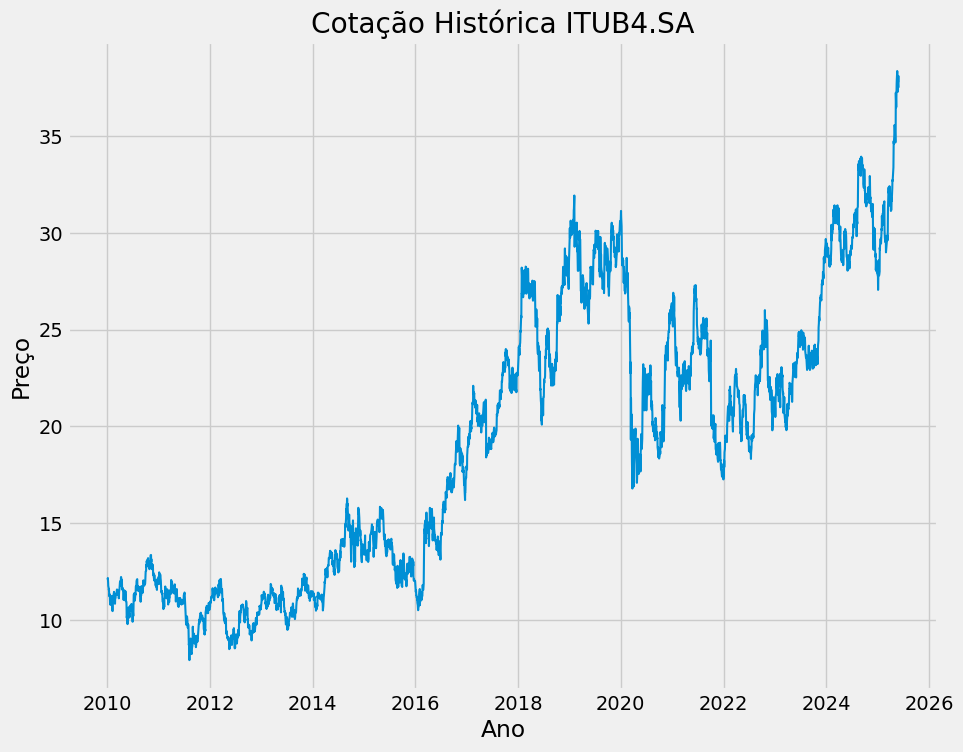

In [14]:
# Carregando a base de dados e fazendo os checks iniciais

plt.style.use("fivethirtyeight")

# Carrega a base
ticker = "ITUB4.SA"
inicio = "2010-01-01"
fim = datetime.today().strftime("%Y-%m-%d")
df1 = yf.download(ticker, inicio, fim, auto_adjust=False)
df1.columns=df1.columns.get_level_values(0)

with plt.style.context("fivethirtyeight"):
    plt.figure(figsize = (10, 8))
    plt.plot(df1["Adj Close"], linewidth = 1.5)
    plt.xlabel("Ano")
    plt.ylabel("Preço")
    plt.title("Cotação Histórica " + ticker)
    plt.show();

In [15]:
# Calculando os retornos diários, dentro e fora do dataframe

df1["Retorno"] = df1["Adj Close"].pct_change(1)

retornos = df1["Adj Close"].pct_change(1).dropna().to_numpy()

In [16]:
retornos

array([ 0.00648101, -0.00866747, -0.01024318, ...,  0.00793649,
       -0.00813642, -0.00793859])

In [17]:
# Vamos considerar 3 anos para frente e que 1 ano tenha 252 dias úteis 

anos = 3
num_dias = anos * 252
ultimo_preco = float(df1["Adj Close"].tail(1))

In [18]:
ultimo_preco

37.4900016784668

In [19]:
# E vamos calcular o drawdown máximo

# Simula os retornos diários dos próximos 3 anos
sim_ret = np.random.choice(retornos, size = num_dias, replace = True)

# Faz o cálculo do valor da carteira com retorno composto
sim_val = ultimo_preco*(1 + sim_ret).cumprod()

# Calcula o valor máximo da carteira simulada
max_val = np.maximum.accumulate(sim_val)

# Encontra o drawdown máximo
max_dd = np.max((max_val - sim_val)/max_val)

max_dd

0.5364704580415984

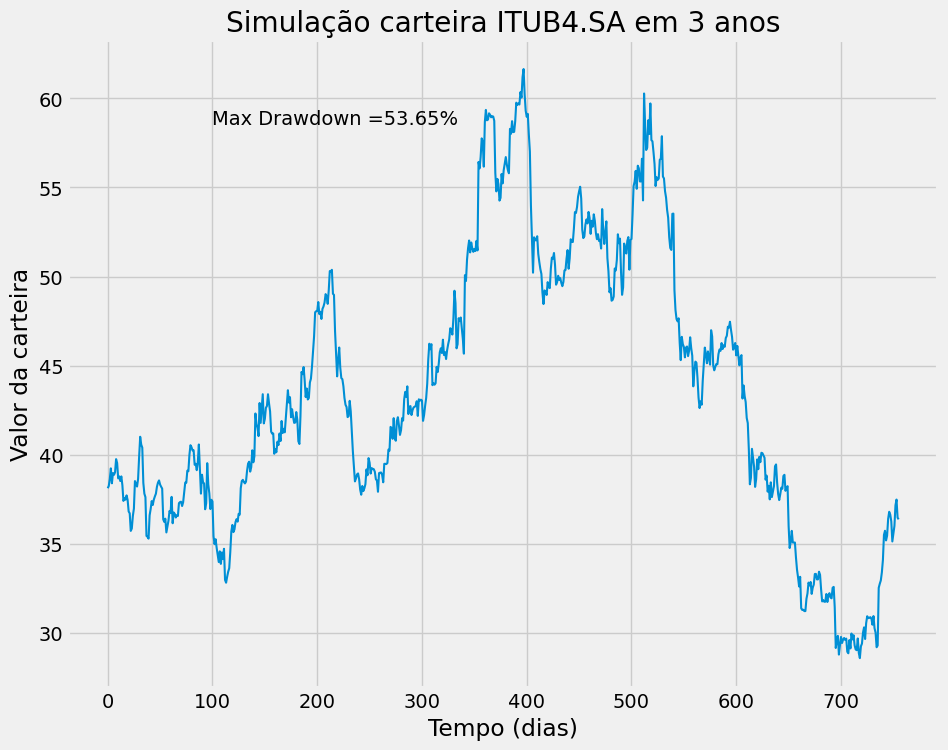

In [20]:
# Visualização da simulação do valor da carteira

with plt.style.context("fivethirtyeight"):
    plt.figure(figsize = (10, 8))
    plt.plot(sim_val, linewidth = 1.5)
    plt.xlabel("Tempo (dias)")
    plt.ylabel("Valor da carteira")
    plt.annotate("Max Drawdown =" + str(round(max_dd*100, 2)) + "%", (100, np.max(sim_val)*0.95))
    plt.title("Simulação carteira " + ticker + " em " + str(anos) + " anos")
    plt.show();

In [21]:
# Vamos ao Monte Carlo com X simulações 

num_sim = 100000

dd = np.array([])

for n in range(num_sim): # basta colocar a lógica anterior dentro de um laço for
    # Simula os retornos diários dos próximos 3 anos
    sim_ret = np.random.choice(retornos, size = num_dias, replace = True)

    # Faz o cálculo do valor da carteira com retorno composto
    sim_val = ultimo_preco*(1 + sim_ret).cumprod()

    # Calcula o valor máximo da carteira simulada
    max_val = np.maximum.accumulate(sim_val)

    # Encontra o drawdown máximo
    max_dd = np.max((max_val - sim_val)/max_val)
    dd = np.append(dd, max_dd)

In [22]:
dd

array([0.33097164, 0.69237624, 0.39236653, ..., 0.5395264 , 0.49923558,
       0.35332245])

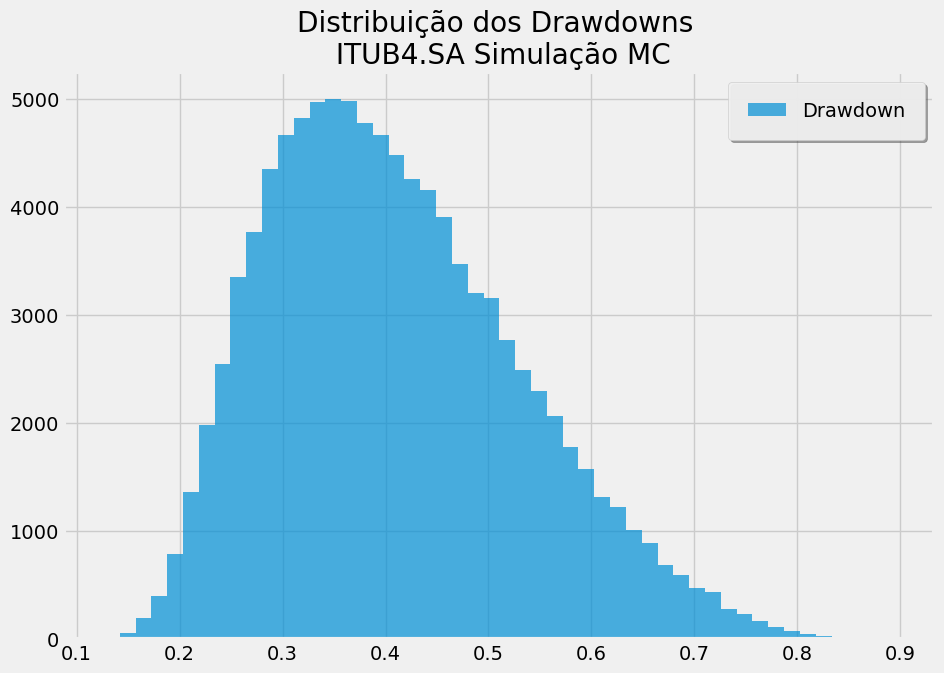

In [23]:
# Vamos visualizar a distribuição dos drawdowns

config = dict(histtype = "stepfilled", alpha = 0.7, density = False, bins = 50)

plt.figure(figsize = (10,7))
plt.hist(dd, **config, label = "Drawdown")

# Formataçao da legenda - Valida para qualquer tipo de grafico
plt.legend(loc = "upper right"
           , frameon = True
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1)
plt.title("Distribuição dos Drawdowns \n " + ticker + " Simulação MC")
plt.show();

In [24]:
# Por fim, as estatísticas importantes

print("Para o ativo " + ticker + " segundo uma simulação de Monte Carlo,")
print("com " + str(num_sim) + " simulações, em " + str(anos) + " anos podemos esperar:")
print()
print("---------------------------------------------------------")
print("Drawdown médio " + str(round(np.mean(dd*100), 2)) + "%")
print()
print("Com: ")
print("    50% de probabilidade, o DD será maior do que " + str(round(np.median(dd*100), 2)) + "%")
print("    25% de probabilidade, o DD será maior do que " + str(round(np.percentile(dd*100, 75), 2)) + "%")
print("     5% de probabilidade, o DD será maior do que " + str(round(np.percentile(dd*100, 95), 2)) + "%")
print("---------------------------------------------------------")
print()
print("Período dos parâmetros para a simulação: " + inicio  + " à " + fim)

Para o ativo ITUB4.SA segundo uma simulação de Monte Carlo,
com 100000 simulações, em 3 anos podemos esperar:

---------------------------------------------------------
Drawdown médio 40.91%

Com: 
    50% de probabilidade, o DD será maior do que 39.39%
    25% de probabilidade, o DD será maior do que 48.9%
     5% de probabilidade, o DD será maior do que 63.45%
---------------------------------------------------------

Período dos parâmetros para a simulação: 2010-01-01 à 2025-05-30


Quanto voce pode ter alocado em uma carteira e perder

O problema da simulação de monte carlo é que ela admite que os dados pertencem a uma distribuição normal